In [1]:
import sys
sys.path.append("..")
import torch
from omegaconf import OmegaConf
from ccreaim.utils import util, dataset, cfg_classes, audio_tools
from ccreaim.model import operate, e2e_chunked
from pathlib import Path
from torch.nn import functional as F

In [2]:
checkpoint_path = "/home/baffyb1/CCREAIM/CCREAIM/logs/multirun/2022-11-24/e2e-chunked_res-ae_train_11-58-40/0/checkpoints/e2e-chunked_res-ae_seqlen-4096_bs-64_lr-1e-05_seed-0_ep-040.pt"

In [3]:
# Fetch the model:
        # testing load an existing trained one
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model_state_dict = checkpoint["model_state_dict"]
hyper_cfg_schema = OmegaConf.structured(cfg_classes.HyperConfig)
conf = OmegaConf.create(checkpoint["hyper_config"])
get_model = operate.get_model_init_function(conf)
model = get_model()
model.load_state_dict(model_state_dict)
model = model.eval()

In [8]:
test_dataset = dataset.ChunkedAudioDataset(Path("/scratch/other/sopi/CCREAIM/datasets/test/out/chopped_65536"), 
                            seq_len=4096, seq_num=16)
wave, _, padding = test_dataset[0]

In [11]:
with torch.inference_mode():
    flat_wave = wave.flatten().unsqueeze(0)
    print(wave.size())
    cut_wave = wave[:8]

    #pred = model(wave.unsqueeze(0), padding.unsqueeze(0))
    
    in_wave = cut_wave
    pred = model.generate(in_wave.unsqueeze(0), 8, 2, 12)
    print(pred.size())
    
    # pred, mu, sigma = model(flat_wave.unsqueeze(0))
    flat_pred = pred.flatten().unsqueeze(0)

torch.Size([16, 4096])
torch.Size([1, 512, 32])
torch.Size([1, 65, 32])
torch.Size([1, 66, 32])
torch.Size([1, 67, 32])
torch.Size([1, 68, 32])
torch.Size([1, 69, 32])
torch.Size([1, 70, 32])
torch.Size([1, 71, 32])
torch.Size([1, 72, 32])
torch.Size([1, 73, 32])
torch.Size([1, 74, 32])
torch.Size([1, 75, 32])
torch.Size([1, 76, 32])
torch.Size([1, 77, 32])
torch.Size([1, 78, 32])
torch.Size([1, 79, 32])
torch.Size([1, 80, 32])
torch.Size([1, 81, 32])
torch.Size([1, 82, 32])
torch.Size([1, 83, 32])
torch.Size([1, 84, 32])
torch.Size([1, 85, 32])
torch.Size([1, 86, 32])
torch.Size([1, 87, 32])
torch.Size([1, 88, 32])
torch.Size([1, 89, 32])
torch.Size([1, 90, 32])
torch.Size([1, 91, 32])
torch.Size([1, 92, 32])
torch.Size([1, 93, 32])
torch.Size([1, 94, 32])
torch.Size([1, 95, 32])
torch.Size([1, 96, 32])
torch.Size([1, 97, 32])
torch.Size([1, 98, 32])
torch.Size([1, 99, 32])
torch.Size([1, 100, 32])
torch.Size([1, 101, 32])
torch.Size([1, 102, 32])
torch.Size([1, 103, 32])
torch.Size([

In [6]:
print(flat_wave.size())
print(flat_wave.squeeze()[:20])
print(mu.size())
print(mu.squeeze()[:20])
print(sigma.squeeze()[:20])
print(flat_pred.squeeze()[:20])

torch.Size([1, 65536])
tensor([ 0.0115,  0.0137,  0.0116,  0.0095,  0.0043, -0.0064, -0.0147, -0.0212,
        -0.0212, -0.0113, -0.0050, -0.0068, -0.0123, -0.0135, -0.0045,  0.0093,
         0.0194,  0.0194,  0.0151,  0.0121])


NameError: name 'mu' is not defined

In [ ]:
print(F.mse_loss(flat_pred, flat_wave))
print(torch.abs(flat_pred - flat_wave).mean())

/tmp/ipykernel_5617/2988544721.py:1: UserWarning: Using a target size (torch.Size([1, 65536])) that is different to the input size (torch.Size([1, 61440])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(flat_pred, flat_wave))


RuntimeError: The size of tensor a (61440) must match the size of tensor b (65536) at non-singleton dimension 1

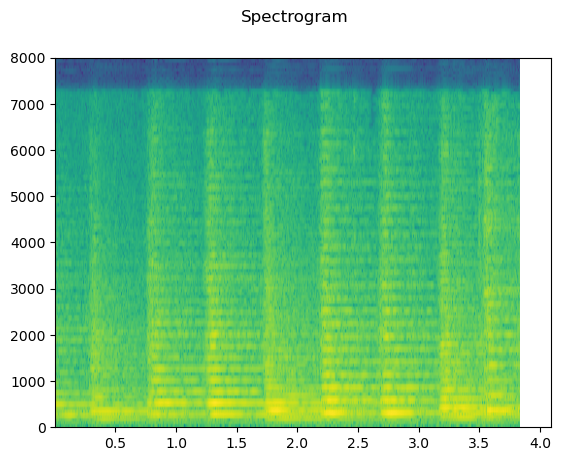

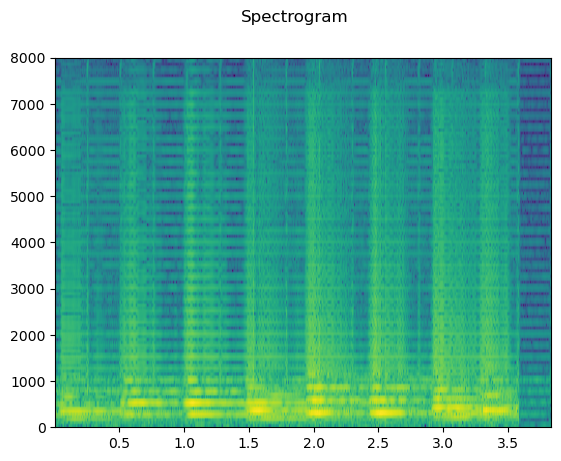

In [ ]:
audio_tools.plot_specgram(flat_wave, 16000)
audio_tools.plot_specgram(flat_pred, 16000)

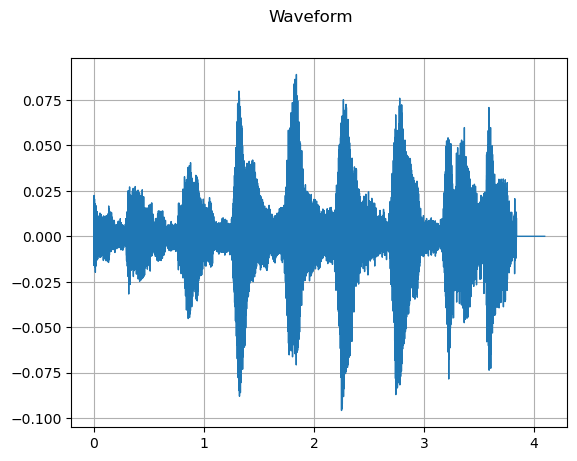

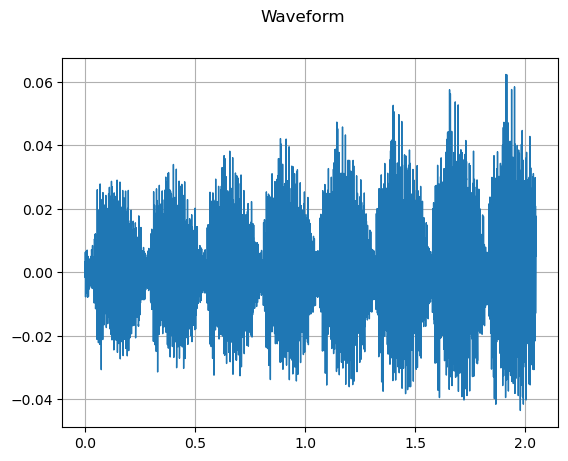

In [ ]:
audio_tools.plot_waveform(flat_wave, 16000)
audio_tools.plot_waveform(flat_pred, 16000)

In [12]:
audio_tools.play_audio(flat_wave, 16000)
audio_tools.play_audio(flat_pred, 16000)